In [1]:
import os
import sys
import time
import datetime
import argparse
import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import random 
import torch.nn as nn

from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
import shuttle
import glob
import matplotlib.pyplot as plt


# Utility Functions

In [2]:

def to_cpu(tensor):
    return tensor.detach().cpu()
    
def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs

def rescale_boxes(boxes, current_dim, original_shape):
    """ Rescales bounding boxes to the original shape """
    orig_h, orig_w = original_shape
    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x
    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h
    return boxes


def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options


def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):


    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    best_ious, best_n = ious.max(0)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf

def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names
def pad_to_square(img, pad_value):
    c, h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)

    return img, pad


def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :4] = xywh2xyxy(prediction[..., :4])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        image_pred = image_pred[image_pred[:, 4] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 5:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :5], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :4].unsqueeze(0), detections[:, :4]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 4:5]
            # Merge overlapping bboxes by order of confidence
            detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output


def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i]
        pred_boxes = output[:, :4]
        pred_scores = output[:, 4]
        pred_labels = output[:, -1]

        true_positives = np.zeros(pred_boxes.shape[0])

        annotations = targets[targets[:, 0] == sample_i][:, 1:]
        target_labels = annotations[:, 0] if len(annotations) else []
        if len(annotations):
            detected_boxes = []
            target_boxes = annotations[:, 1:]

            for pred_i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):

                # If targets are found break
                if len(detected_boxes) == len(annotations):
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)
                if iou >= iou_threshold and box_index not in detected_boxes:
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]
        batch_metrics.append([true_positives, pred_scores, pred_labels])
    return batch_metrics


def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou



def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in tqdm.tqdm(unique_classes, desc="Computing AP"):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum()
            tpc = (tp[i]).cumsum()

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = np.array(p), np.array(r), np.array(ap)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype("int32")


# CoCo DataSet Download

In [5]:
# Coco API cloning
!git clone https://github.com/pdollar/coco
!cd coco

!mkdir images

#Downloading images 
!wget -c https://pjreddie.com/media/files/train2014.zip
!wget -c https://pjreddie.com/media/files/val2014.zip

!unzip -q train2014.zip -d images
!unzip -q val2014.zip   -d images

# Download COCO Metadata
!wget -c https://pjreddie.com/media/files/instances_train-val2014.zip
!wget -c https://pjreddie.com/media/files/coco/5k.part
!wget -c https://pjreddie.com/media/files/coco/trainvalno5k.part
!wget -c https://pjreddie.com/media/files/coco/labels.tgz
!tar xzf labels.tgz
!unzip -q instances_train-val2014.zip

# Set Up Image Lists
!paste <(awk "{print \"$PWD\"}" <5k.part) 5k.part | tr -d '\t' > 5k.txt
!paste <(awk "{print \"$PWD\"}" <trainvalno5k.part) trainvalno5k.part | tr -d '\t' > trainvalno5k.txt


Cloning into 'coco'...
remote: Enumerating objects: 959, done.
remote: Total 959 (delta 0), reused 0 (delta 0), pack-reused 959
Receiving objects: 100% (959/959), 11.69 MiB | 5.81 MiB/s, done.
Resolving deltas: 100% (570/570), done.
--2019-11-20 09:08:18--  https://pjreddie.com/media/files/train2014.zip
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510435630 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  8.39MB/s    in 18m 37s 

2019-11-20 09:26:55 (11.5 MB/s) - ‘train2014.zip’ saved [13510435630/13510435630]

--2019-11-20 09:26:57--  https://pjreddie.com/media/files/val2014.zip
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [applicat

In [0]:
# !chmod +x /content/PyTorch-YOLOv3/config/create_custom_model.sh
# ! /content/PyTorch-YOLOv3/config/./create_custom_model.sh 2

# Custom DataSet

In [30]:
#Some Paramters 
batch_size = 8
model_path = 'C:\\Users\\iamrehman\\Google Drive (i160306@nu.edu.pk)\\PyTorch-YOLOv3\\config\\yolov3-tiny.cfg'
class_path = '/content/coco.names'

train_path = '/content/pizza_hotdog_train.txt'
valid_path = '/content/pizza_hotdog_test.txt'
img_size = 416

conf_thres = 0.001
nms_thres = 0.5
iou_thres = 0.5

class_names = load_classes('C:\\Users\\iamrehman\\Google Drive (i160306@nu.edu.pk)\\PyTorch-YOLOv3\\data\\coco.names')

# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class CustomCocoDataSet(Dataset):
    def __init__(self, list_path, img_size=416, augment=True, multiscale=False, normalized_labels=True, Train=True):
        with open(list_path, "r") as file:
            self.img_files = file.readlines()


        self.img_files = np.unique( np.array(self.img_files) )
    
        self.label_files = [
            path.replace("images", "labels").replace(".png", ".txt").replace(".jpg", ".txt")
            for path in self.img_files
        ]

        # #Let's remove some training data
        # if Train:
        #     for i in range(60000):
        #         del_index = random.randint(0, len(self.img_files)-1 )
        #         del self.label_files[del_index]
        #         del self.img_files[del_index]

        # else: #validation data 
        #     for i in range(4500):
        #         del_index = random.randint(0, len(self.img_files)-1 )
        #         del self.label_files[del_index]
        #         del self.img_files[del_index]

        self.img_size = img_size
        self.max_objects = 100
        self.augment = augment
        self.multiscale = multiscale
        self.normalized_labels = normalized_labels
        self.min_size = self.img_size - 3 * 32
        self.max_size = self.img_size + 3 * 32
        self.batch_count = 0

    def __getitem__(self, index):

        # ---------
        #  Image
        # ---------

        img_path = self.img_files[index % len(self.img_files)].rstrip()

        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(Image.open(img_path).convert('RGB'))
    
        # Handle images with less than three channels
        if len(img.shape) != 3:
            img = img.unsqueeze(0)
            img = img.expand((3, img.shape[1:]))

        _, h, w = img.shape
        h_factor, w_factor = (h, w) if self.normalized_labels else (1, 1)
        # Pad to square resolution

        img, pad = pad_to_square(img, 0)
        _, padded_h, padded_w = img.shape

        # ---------
        #  Label
        # ---------

        label_path = self.label_files[index % len(self.img_files)].rstrip()

        targets = None
        if os.path.exists(label_path):
            np_labs =  np.loadtxt(label_path).reshape(-1, 5)

            np_labs =  np_labs [np.where ( (np_labs[:,0] == 53) | ( np_labs[:,0]==52 ) ) ]

            if np_labs[:,0][0] == 52:
                np_labs[:,0]  = 0
            else:
                np_labs[:,0] = 1
                
            # print(np_labs)
            boxes = torch.from_numpy( np_labs )
            
            # print(boxes)
            # Extract coordinates for unpadded + unscaled image
            x1 = w_factor * (boxes[:, 1] - boxes[:, 3] / 2)
            y1 = h_factor * (boxes[:, 2] - boxes[:, 4] / 2)
            x2 = w_factor * (boxes[:, 1] + boxes[:, 3] / 2)
            y2 = h_factor * (boxes[:, 2] + boxes[:, 4] / 2)
            # Adjust for added padding
            x1 += pad[0]
            y1 += pad[2]
            x2 += pad[1]
            y2 += pad[3]
            # Returns (x, y, w, h)
            boxes[:, 1] = ((x1 + x2) / 2) / padded_w
            boxes[:, 2] = ((y1 + y2) / 2) / padded_h
            boxes[:, 3] *= w_factor / padded_w
            boxes[:, 4] *= h_factor / padded_h

            targets = torch.zeros((len(boxes), 6))
            targets[:, 1:] = boxes

        return img_path, img, targets


    def collate_fn(self, batch):
        paths, imgs, targets = list(zip(*batch))
        # Remove empty placeholder targets
        targets = [boxes for boxes in targets if boxes is not None]
        # Add sample index to targets
        for i, boxes in enumerate(targets):
            boxes[:, 0] = i
        targets = torch.cat(targets, 0)
        # Selects new image size every tenth batch
        if self.multiscale and self.batch_count % 10 == 0:
            self.img_size = random.choice(range(self.min_size, self.max_size + 1, 32))
        # Resize images to input shape
        imgs = torch.stack([resize(img, self.img_size) for img in imgs])
        self.batch_count += 1
        return paths, imgs, targets

    def __len__(self):
        return len(self.img_files)

#train loader 
dataset_train= CustomCocoDataSet(train_path, img_size= 416, Train=True)
train_loader = torch.utils.data.DataLoader( dataset_train, batch_size= batch_size, shuffle=False, num_workers=1, collate_fn=dataset_train.collate_fn  )


FileNotFoundError: [Errno 2] No such file or directory: '/content/pizza_hotdog_train.txt'

In [0]:
t = next(iter(train_loader))

# Creating DataLoaders

In [0]:
#validation loader with 500 images
dataset_val = CustomCocoDataSet(valid_path, img_size= 416, Train=False)
valid_loader = torch.utils.data.DataLoader( dataset_val, batch_size= batch_size, shuffle=False, num_workers=1, collate_fn=dataset_val.collate_fn  )

In [0]:
# with open("pizza_hotdog.txt","w") as output:
#     output.writelines(["%s\n" % item  for item in image_files])

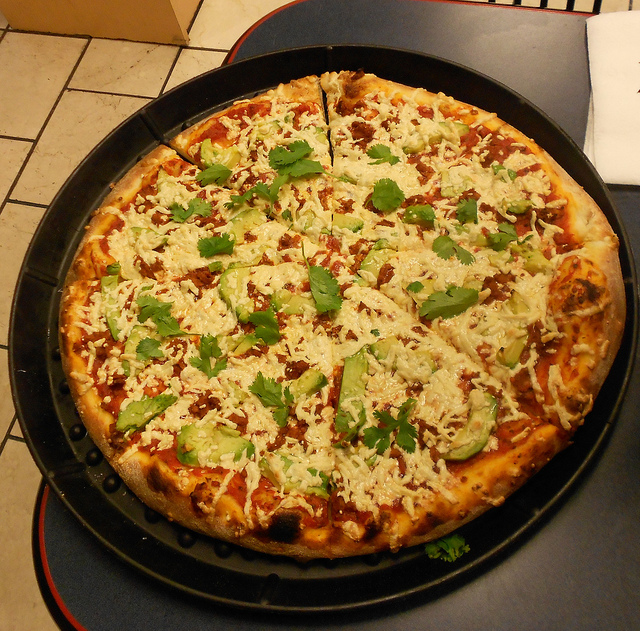

In [0]:
Image.open('/content/images/train2014/COCO_train2014_000000567914.jpg')

# Model

## Layers

In [6]:
class Upsample(nn.Module):
    """ nn.Upsample is deprecated """

    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x


class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()


class YOLOLayer(nn.Module):

    def __init__(self, anchors, num_classes, img_dim=416):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = 0.5
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.obj_scale = 1
        self.noobj_scale = 100
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0  # grid size

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    def forward(self, x, targets=None, img_dim=None):

        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        self.img_dim = img_dim
        num_samples = x.size(0)
        grid_size = x.size(2)
        # print(x.shape)
  
        prediction = (
            x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # If grid size does not match current we compute new offsets
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        output = torch.cat(
            (
                pred_boxes.view(num_samples, -1, 4) * self.stride,
                pred_conf.view(num_samples, -1, 1),
                pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )

        if targets is None:
            return output, 0
        else:
            iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf = build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres,
            )

            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = self.mse_loss(x[obj_mask], tx[obj_mask])
            loss_y = self.mse_loss(y[obj_mask], ty[obj_mask])
            loss_w = self.mse_loss(w[obj_mask], tw[obj_mask])
            loss_h = self.mse_loss(h[obj_mask], th[obj_mask])

            loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask])
            loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
            loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask])
            total_loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

            # Metrics
            cls_acc = 100 * class_mask[obj_mask].mean()
            conf_obj = pred_conf[obj_mask].mean()
            conf_noobj = pred_conf[noobj_mask].mean()
            conf50 = (pred_conf > 0.5).float()
            iou50 = (iou_scores > 0.5).float()
            iou75 = (iou_scores > 0.75).float()
            detected_mask = conf50 * class_mask * tconf
            precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
            recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
            recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)

            self.metrics = {
                "loss": to_cpu(total_loss).item(),
                "x": to_cpu(loss_x).item(),
                "y": to_cpu(loss_y).item(),
                "w": to_cpu(loss_w).item(),
                "h": to_cpu(loss_h).item(),
                "conf": to_cpu(loss_conf).item(),
                "cls": to_cpu(loss_cls).item(),
                "cls_acc": to_cpu(cls_acc).item(),
                "recall50": to_cpu(recall50).item(),
                "recall75": to_cpu(recall75).item(),
                "precision": to_cpu(precision).item(),
                "conf_obj": to_cpu(conf_obj).item(),
                "conf_noobj": to_cpu(conf_noobj).item(),
                "grid_size": grid_size,
            }

            return output, total_loss

## Backbone

In [26]:
class NetWork(nn.Module):
    def __init__(self):

        super(NetWork,self).__init__()
        #0 
        self.layer0 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, stride= 1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=16,momentum=0.9),
            nn.LeakyReLU()                       
        )        
        #1
        self.layer1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        #2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,3,1,1),
            nn.BatchNorm2d(num_features=32,momentum=0.9),
            nn.LeakyReLU()
        )
        #3
        self.layer3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        #4
        self.layer4 = nn.Sequential(
            nn.Conv2d(32,64,3,1,1),
            nn.BatchNorm2d(num_features=64,momentum=0.9),
            nn.LeakyReLU(negative_slope=0.1)
        )
        #5
        self.layer5 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        #6
        self.layer6 = nn.Sequential(
            nn.Conv2d(64,128,3,1,1),
            nn.BatchNorm2d(num_features=128,momentum=0.9),
            nn.LeakyReLU(negative_slope=0.1)
        )
        #7
        self.layer7 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        #8
        self.layer8 = nn.Sequential(
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(num_features=256,momentum=0.9),
            nn.LeakyReLU(negative_slope=0.1)
        )       
        #9
        self.layer9 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        #10
        self.layer10 = nn.Sequential(
            nn.Conv2d(256,512,3,1,1),
            nn.BatchNorm2d(num_features=512,momentum=0.9),
            nn.LeakyReLU(negative_slope=0.1)
        )
        #11
        self.layer11 = nn.Sequential(
           nn.ZeroPad2d(padding = (0,1,0,1)),
           nn.MaxPool2d(2,2) 
        )
        
        #12
        self.layer12 = nn.Sequential(
            nn.Conv2d(512,1024,3,1,1),
            nn.BatchNorm2d(num_features=1024,momentum=0.9),
            nn.LeakyReLU(negative_slope=0.1)
        )
        #13
        self.layer13 = nn.Sequential(
            nn.Conv2d(1024,256,1,1),
            nn.BatchNorm2d(num_features=256,momentum=0.9),
            nn.LeakyReLU(negative_slope=0.1)
        )
        #14
        self.layer14 = nn.Sequential(
            nn.Conv2d(256,512,3,1,1),
            nn.BatchNorm2d(num_features=512,momentum=0.9),
            nn.LeakyReLU(negative_slope=0.1)
        )

        #15
        self.layer15= nn.Sequential(
            nn.Conv2d(512,255,3,1,1)
        )
        
        #16 yolo 
        self.layer16 = YOLOLayer(anchors=[(81, 82), (135, 169), (344, 319)],num_classes=2,img_dim=416) 

        #layer17
        self.layer17 = nn.Sequential(
            EmptyLayer()
        )

        #layer18
        self.layer18 = nn.Sequential(
            nn.Conv2d(256,128,1,1),
            nn.BatchNorm2d(num_features=128,momentum=0.9),
            nn.LeakyReLU(negative_slope=0.1)
        )

        #layer19
        self.layer19= nn.Sequential(
            Upsample(2)
        )

        #layer20
        self.layer20 = nn.Sequential(
            EmptyLayer()
        )

        #21
        self.layer21 = nn.Sequential(
            nn.Conv2d(1152,256,3,1,1),
            nn.BatchNorm2d(num_features=256,momentum=0.9),
            nn.LeakyReLU(negative_slope=0.1)
        )
        
        #22
        self.layer22 = nn.Sequential(
            nn.Conv2d(256,255,1,1)
        )

        
        #23 yolo 
        self.layer23 = YOLOLayer(anchors=[(23, 27), (37, 58), (81, 82)],num_classes=2,img_dim=416)
            
       
    def forward(self,x,targets=None):
        img_dim = x.shape[2]
        loss = 0 
        layer_outputs, yolo_outputs = [], []

        x = self.layer0(x)
        layer_outputs.append(x)
        x = self.layer1(x)
        layer_outputs.append(x)

        x = self.layer2(x)
        layer_outputs.append(x)

        x = self.layer3(x)
        layer_outputs.append(x)

        x = self.layer4(x)
        layer_outputs.append(x)

        x = self.layer5(x) 
        layer_outputs.append(x)

        x = self.layer6(x)
        layer_outputs.append(x)

        x = self.layer7(x)
        layer_outputs.append(x)

        x = self.layer8(x)
        layer_outputs.append(x)

        x = self.layer9(x)
        layer_outputs.append(x)

        x = self.layer10(x)
        layer_outputs.append(x)

        x = self.layer11(x)
        layer_outputs.append(x)
        
        x = self.layer12(x)
        layer_outputs.append(x)

        x = self.layer13(x)
        layer_outputs.append(x)

        x = self.layer14(x)
        layer_outputs.append(x)

        x = self.layer15(x)
        layer_outputs.append(x)

   
        x, yolo1Loss = self.layer16(x,targets,img_dim)
        yolo_outputs.append(x)
        loss+= yolo1Loss
        layer_outputs.append(x)

        #layer 17 route
        x = layer_outputs[-4]
        layer_outputs.append(x)

        x = self.layer18(x)
        layer_outputs.append(x)

        x = self.layer19(x)
        layer_outputs.append(x)

        #layer 20 route
        x = torch.cat( [layer_outputs[-2] ,layer_outputs[-8] ],1)
        layer_outputs.append(x)

        x = self.layer21(x)
        layer_outputs.append(x)

        x = self.layer22(x)
        layer_outputs.append(x)

        x, yolo2Loss = self.layer23(x,targets,img_dim)
        yolo_outputs.append(x)
        loss+= yolo2Loss
        layer_outputs.append(x)

        yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
        return yolo_outputs if targets is None else (loss, yolo_outputs)              

# yolo

In [8]:

def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}", nn.BatchNorm2d(filters, momentum=0.9, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[1:][i] for i in layers])
            modules.add_module(f"route_{module_i}", EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_size = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list


In [9]:
class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.yolo_layers = [layer[0] for layer in self.module_list if hasattr(layer[0], "metrics")]
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x, targets=None):
        img_dim = x.shape[2]
        loss = 0
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)~
            elif module_def["type"] == "route":
                x = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                x, layer_loss = module[0](x, targets, img_dim)
                loss += layer_loss
                yolo_outputs.append(x)
            layer_outputs.append(x)
        yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
        return yolo_outputs if targets is None else (loss, yolo_outputs)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        with open(weights_path, "rb") as f:
            header = np.fromfile(f, dtype=np.int32, count=5)  # First five are header values
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        if "darknet53.conv.74" in weights_path:
            cutoff = 75

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()



## Setup

In [31]:
model = Darknet(model_path).to(device)

In [29]:
#!/bin/bash
# Download weights for vanilla YOLOv3
!wget -c https://pjreddie.com/media/files/yolov3.weights
# # # Download weights for tiny YOLOv3
# !wget -c https://pjreddie.com/media/files/yolov3-tiny.weights
# # Download weights for backbone network
# !wget -c https://pjreddie.com/media/files/darknet53.conv.74


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [34]:
optimizer = torch.optim.Adam(model.parameters())

In [35]:
model.load_darknet_weights("C:\\Users\\iamrehman\\Google Drive (i160306@nu.edu.pk)\\PyTorch-YOLOv3\\weights\\yolov3-tiny.weights")

# Training

In [36]:
epochs = 1
gradient_accumulations = 2

In [0]:
import warnings
warnings.filterwarnings("ignore") #Don't warn me. I have faith in my code!

In [14]:
from IPython.display import clear_output

import tqdm

In [0]:
model.load_darknet_weights("/content/yolov3.weights")

In [0]:
def train (epoch_num):
    for epoch in range(epochs):
        model.train()
        
        print("Training")

        loop = tqdm.tqdm_notebook(train_loader)

        for batch_i, (_, imgs, targets) in enumerate(loop):
            
            batches_done = len(train_loader) * epoch + batch_i

            imgs = Variable(imgs.to(device))
            targets = Variable(targets.to(device), requires_grad=False)

            loss, outputs = model(imgs, targets)
            loss.backward()

            if batches_done % 2:
                # Accumulates gradient before each step
              optimizer.step()
              optimizer.zero_grad()

            log_str = "\n[Epoch Number] ---->%d\n" % (epoch_num)

            # metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]
           
            log_str += f"\nTotal loss {loss.item()}"
            # model.seen += imgs.size(0)

            del imgs
            del targets
            del outputs
            
            if(batch_i%400)==0:
                print(log_str)

In [0]:
for i in range(1,15):
  train(i)

Training



[Epoch Number] ---->1

Total loss 151.06130981445312

[Epoch Number] ---->1

Total loss 10.146056175231934
Training



[Epoch Number] ---->2

Total loss 9.830682754516602

[Epoch Number] ---->2

Total loss 6.4299468994140625
Training



[Epoch Number] ---->3

Total loss 6.81162166595459

[Epoch Number] ---->3

Total loss 5.929751396179199
Training



[Epoch Number] ---->4

Total loss 5.534079074859619

[Epoch Number] ---->4

Total loss 5.041717052459717
Training



[Epoch Number] ---->5

Total loss 4.308204650878906

[Epoch Number] ---->5

Total loss 5.0677595138549805
Training



[Epoch Number] ---->6

Total loss 4.280800819396973

[Epoch Number] ---->6

Total loss 4.078218936920166
Training



[Epoch Number] ---->7

Total loss 3.359245538711548

[Epoch Number] ---->7

Total loss 5.830325603485107
Training



[Epoch Number] ---->8

Total loss 3.394380807876587

[Epoch Number] ---->8

Total loss 3.6399590969085693
Training



[Epoch Number] ---->9

Total loss 2.088439464569092

[Epoch Number] ---->9

Total loss 4.13822078704834
Training



[Epoch Number] ---->10

Total loss 3.9591150283813477

[Epoch Number] ---->10

Total loss 4.997045516967773
Training



[Epoch Number] ---->11

Total loss 1.9249615669250488

[Epoch Number] ---->11

Total loss 3.6685566902160645
Training



[Epoch Number] ---->12

Total loss 2.942328691482544

[Epoch Number] ---->12

Total loss 2.9610953330993652
Training



[Epoch Number] ---->13

Total loss 1.8400959968566895

[Epoch Number] ---->13

Total loss 2.2763943672180176
Training



[Epoch Number] ---->14

Total loss 2.103001117706299

[Epoch Number] ---->14

Total loss 1.8262773752212524


In [0]:
model_state = {"model": model.state_dict(), "optimizer": optimizer.state_dict(), "epoch": 15}

torch.save(model_state,"pizza_hotdog_weights")

In [25]:

import os
import sys
import time
import datetime
import argparse

In [0]:
!pip install terminaltables
from terminaltables import AsciiTable


  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15354 sha256=e966270ccbb7f8a7fe4b0c4cf6200b380f4fbd4d66e0b5f9d5a1a0fce11749b5
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables


In [0]:

metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]

for epoch in range(1):
    model.train()
    start_time = time.time()
    for batch_i, (_, imgs, targets) in enumerate(train_loader):
        batches_done = len(train_loader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % 2:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, 1, batch_i, len(train_loader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # # Tensorboard logging
            # tensorboard_log = []
            # for j, yolo in enumerate(model.yolo_layers):
            #     for name, metric in yolo.metrics.items():
            #         if name != "grid_size":
            #             tensorboard_log += [(f"{name}_{j+1}", metric)]
            # tensorboard_log += [("loss", loss.item())]
            # logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        # Determine approximate time left for epoch
        epoch_batches_left = len(train_loader) - (batch_i + 1)
        time_left = datetime.timedelta(seconds=epoch_batches_left * (time.time() - start_time) / (batch_i + 1))
        log_str += f"\n---- ETA {time_left}"

        print(log_str)

    #     model.seen += imgs.size(0)
    #     precision, recall, AP, f1, ap_class = evaluate(
    #             model,
    #             dataloader = valid_loader,
    #             iou_thres=0.5,
    #             conf_thres=0.5,
    #             nms_thres=0.5,
    #             img_size=img_size
    #         )

    #     evaluation_metrics = [
    #         ("val_precision", precision.mean()),
    #         ("val_recall", recall.mean()),
    #         ("val_mAP", AP.mean()),
    #         ("val_f1", f1.mean()),
    #     ]
    #     logger.list_of_scalars_summary(evaluation_metrics, epoch)

    #     # Print class APs and mAP
    #     ap_table = [["Index", "Class name", "AP"]]
    #     for i, c in enumerate(ap_class):
    #         ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
    #     print(AsciiTable(ap_table).table)
    #     print(f"---- mAP {AP.mean()}")

    # if epoch % opt.checkpoint_interval == 0:
    #     torch.save(model.state_dict(), f"checkpoints/yolov3_ckpt_%d.pth" % epoch)

In [0]:
train(2) 
 

# Testing Model

In [0]:
def evaluate(model, dataloader, iou_thres, conf_thres, nms_thres, img_size):
    model.eval()
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    batch_size = 1
    labels = []
    sample_metrics = [] 
    for batch_i, (_, imgs, targets) in enumerate(tqdm.tqdm_notebook(train_loader)):
        
        
        # Extract labels
        labels += targets[:, 1].tolist()
        # Rescale target

        targets[:, 2:] = xywh2xyxy(targets[:, 2:])
        targets[:, 2:] *= img_size
        imgs = Variable(imgs.type(Tensor), requires_grad=False)

        with torch.no_grad():
            outputs = model(imgs)
            outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)

        sample_metrics += get_batch_statistics(outputs, targets, iou_threshold=iou_thres)
        break

    # Concatenate sample statistics
    true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
    precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)

    return precision, recall, AP, f1, ap_class, outputs


#Let's call evaluate function to 

precision, recall, AP, f1, ap_class, out = evaluate(   model,
    dataloader= valid_loader, #validation loader 
    iou_thres=iou_thres,
    conf_thres=conf_thres,
    nms_thres=nms_thres,
    img_size=img_size
)

Computing AP: 100%|██████████| 2/2 [00:00<00:00, 305.06it/s]


In [0]:
import gc
gc.collect()

493

In [0]:

Test_Precision= precision.mean()
Test_recall = recall.mean()
Test_mAP= AP.mean()
Test_f1= f1.mean()


In [0]:
print("test Precision: ", Test_Precision)
print("Test recall: ", Test_recall)
print("Test mAP", Test_mAP)
print("Test f1_Score: ", Test_f1)

test Precision:  0.01347692729484741
Test recall:  0.75
Test mAP 0.6377450980392156
Test f1_Score:  0.026464495815726238


In [0]:
#testing on first image 
model.eval()
test_image = next(iter(valid_loader))[1][0]

test_image = test_image[None,:,:,:].cuda()

In [0]:
next(iter(train_loader))[]

tensor([[0.0000, 1.0000, 0.4774, 0.8018, 0.5276, 0.1288],
        [1.0000, 1.0000, 0.5008, 0.5270, 0.9983, 0.6758],
        [2.0000, 0.0000, 0.7624, 0.6250, 0.3882, 0.3759],
        [2.0000, 0.0000, 0.7624, 0.4118, 0.3670, 0.3794],
        [3.0000, 1.0000, 0.4425, 0.5044, 0.8850, 0.7158],
        [4.0000, 1.0000, 0.4491, 0.5087, 0.3463, 0.2269],
        [5.0000, 1.0000, 0.5000, 0.5105, 1.0000, 0.6312],
        [6.0000, 1.0000, 0.5309, 0.5101, 0.5966, 0.4534],
        [7.0000, 1.0000, 0.4382, 0.6508, 0.3742, 0.3236],
        [7.0000, 1.0000, 0.4958, 0.4727, 0.9303, 0.6350]])

In [0]:
test_image = test_image[None,:,:,:].cuda()

In [0]:
outputs = model(test_image)
outputs = non_max_suppression(outputs, conf_thres=0.8, nms_thres=0.4)

In [0]:
outputs

In [0]:
import os 
# labs = os.listdir("/content/labels/val2014")

text = open('/content/labels/train2014/COCO_train2014_000000003870.txt','r')

text.readlines()

['32 0.619969 0.615437 0.135906 0.152125 \n',
 '0 0.309125 0.572073 0.273656 0.822062 \n',
 '0 0.802250 0.588396 0.222469 0.800000 \n',
 '40 0.974719 0.534531 0.043125 0.112479 \n',
 '52 0.417430 0.767062 0.108609 0.065542 \n',
 '52 0.530062 0.765917 0.099437 0.062917 \n',
 '52 0.449750 0.749844 0.086063 0.069646 \n',
 '52 0.343531 0.740844 0.101125 0.069229 \n',
 '52 0.529070 0.693073 0.069703 0.040646 \n',
 '52 0.388000 0.714844 0.063813 0.040104 \n',
 '52 0.412687 0.698323 0.082219 0.042729 \n',
 '52 0.453023 0.683365 0.068547 0.045687 \n',
 '52 0.504039 0.717271 0.106359 0.050292 \n',
 '56 0.946344 0.864052 0.096062 0.213479 \n',
 '60 0.952539 0.584948 0.094922 0.091229 \n',
 '0 0.575711 0.363271 0.292578 0.676250 \n',
 '0 0.522328 0.894042 0.178375 0.211917 \n',
 '41 0.690633 0.399885 0.042516 0.068771 \n',
 '41 0.911406 0.580479 0.017000 0.064000 \n',
 '48 0.941445 0.702083 0.062484 0.037542 \n',
 '54 0.828898 0.668792 0.048266 0.043333 \n',
 '54 0.904289 0.659250 0.047703 0.0328

In [0]:
detections = outputs[0]

In [26]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
import time

<Figure size 432x288 with 0 Axes>

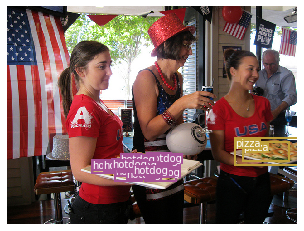

In [0]:
# Create plot
img = np.array(Image.open('/content/images/train2014/COCO_train2014_000000003870.jpg'))
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(img)

# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

classes = load_classes("/content/coco.names")  # Extracts class labels from file


if detections is not None:
    # Rescale boxes to original image
    detections = rescale_boxes(detections, img_size, img.shape[:2])
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

        # print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

        box_w = x2 - x1
        box_h = y2 - y1

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
        # Add the bbox to the plot
        ax.add_patch(bbox)
        # Add label
        plt.text(
            x1,
            y1,
            s=classes[int(cls_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0},
        )

# Save generated image with detections
plt.axis("off")
plt.gca().xaxis.set_major_locator(NullLocator())
plt.gca().yaxis.set_major_locator(NullLocator())


In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

im = np.array(Image.open('/content/images/train2014/COCO_train2014_000000003870.jpg'), dtype=np.uint8)

# Create figure and axes
fig,ax = plt.subplots(1)

if(int(targets[-1])==0):
  fig.suptitle("hotdog")
else:
  fig.suptitle("pizza")
# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((targets[0], targets[1]),targets[2],targets[3],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [19]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
import time

# Test New Images

In [0]:
image = os.listdir('/content/images/train2014')[1]

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator


In [87]:
os.listdir('/content/images/val2014')[4]

'COCO_val2014_000000051025.jpg'

In [0]:
!cp /content/images/val2014/COCO_val2014_000000051025.jpg /content/test_images/

In [15]:
class ImageFolder(Dataset):
    def __init__(self, file_path, img_size=416):
        self.files = file_path
        self.img_size = img_size

    def __getitem__(self, index):
        img_path = self.files
        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(Image.open(img_path))
        # Pad to square resolution
        img, _ = pad_to_square(img, 0)
        # Resize
        img = resize(img, self.img_size)

        return img_path, img

    def __len__(self):
        return 1

In [16]:
 def detect(image_folder):  
   

    os.makedirs("output", exist_ok=True)


    model.eval()  # Set in evaluation mode

    dataloader = DataLoader(
        ImageFolder(image_folder,416),
        batch_size=1,
        shuffle=False
    )

    classes = class_names  # Extracts class labels from file

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    imgs = []  # Stores image paths
    img_detections = []  # Stores detections for each image index

    print("\nPerforming object detection:")
    prev_time = time.time()
    for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
        # Configure input
        input_imgs = Variable(input_imgs.type(Tensor))

        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)
            detections = non_max_suppression(detections, 0.8, 0.4)

        # Log progress
        current_time = time.time()
        inference_time = datetime.timedelta(seconds=current_time - prev_time)
        prev_time = current_time
        print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

        # Save image and detections
        imgs.extend(img_paths)
        img_detections.extend(detections)

    # Bounding-box colors
    cmap = plt.get_cmap("tab20b")
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    print("\nSaving images:")
    # Iterate through images and save plot of detections
    for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):

        print("(%d) Image: '%s'" % (img_i, path))

        # Create plot
        img = np.array(Image.open(path))
        plt.figure()
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        # Draw bounding boxes and labels of detections
        if detections is not None:
            # Rescale boxes to original image
            detections = rescale_boxes(detections, 416, img.shape[:2])
            unique_labels = detections[:, -1].cpu().unique()
            n_cls_preds = len(unique_labels)
            bbox_colors = random.sample(colors, n_cls_preds)
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

                print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

                box_w = x2 - x1
                box_h = y2 - y1

                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                # Create a Rectangle patch
                bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
                # Add the bbox to the plot
                ax.add_patch(bbox)
                # Add label
                plt.text(
                    x1,
                    y1,
                    s=classes[int(cls_pred)],
                    color="white",
                    verticalalignment="top",
                    bbox={"color": color, "pad": 0},
                )

        # Save generated image with detections
        plt.axis("off")
        plt.gca().xaxis.set_major_locator(NullLocator())
        plt.gca().yaxis.set_major_locator(NullLocator())
        filename = path.split("\\")[-1].split(".")[0]
        print(filename)
        plt.savefig(f"output\\out.png", bbox_inches="tight", pad_inches=0.0)
        plt.close()

In [ ]:
import time

while True :
    input_image = open("input\\input.txt",'r').read().splitlines()[0]
    detect(input_image)
    time.sleep(1)

    
    



Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.562652

Saving images:
(0) Image: 'C:\Users\iamrehman\Desktop\maxresdefault.jpg'
	+ Label: person, Conf: 0.99679
maxresdefault

Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.447722

Saving images:
(0) Image: 'C:\Users\iamrehman\Desktop\maxresdefault.jpg'
	+ Label: person, Conf: 0.99679
maxresdefault

Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.469705

Saving images:
(0) Image: 'C:\Users\iamrehman\Desktop\maxresdefault.jpg'
	+ Label: person, Conf: 0.99679
maxresdefault

Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.473698

Saving images:
(0) Image: 'C:\Users\iamrehman\Desktop\maxresdefault.jpg'
	+ Label: person, Conf: 0.99679
maxresdefault

Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.528674

Saving images:
(0) Image: 'C:\Users\iamrehman\Desktop\maxresdefault.jpg'
	+ Label: person, Conf: 0.99679
maxresdefault

Performing object detection:
	+ Ba

c:\users\iamrehman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	+ Label: person, Conf: 0.99963
	+ Label: person, Conf: 0.99181
	+ Label: person, Conf: 0.99959
IMG_0679

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.332166

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_0679.JPG'


c:\users\iamrehman\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	+ Label: person, Conf: 0.99963
	+ Label: person, Conf: 0.99181
	+ Label: person, Conf: 0.99959
IMG_0679

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.306182

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_0679.JPG'
	+ Label: person, Conf: 0.99963
	+ Label: person, Conf: 0.99181
	+ Label: person, Conf: 0.99959
IMG_0679

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.328173

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_0679.JPG'
	+ Label: person, Conf: 0.99963
	+ Label: person, Conf: 0.99181
	+ Label: person, Conf: 0.99959
IMG_0679

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.306185

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_0679.JPG'
	+ Label: person, Conf: 0.99963
	+ Label: person, Conf: 0.99181
	+ Label: person, Conf: 0.99959
IMG_0679

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.306187

Saving images:
(0) Image: 'C:\Users\iamrehman\P

	+ Label: person, Conf: 0.99963
	+ Label: person, Conf: 0.99181
	+ Label: person, Conf: 0.99959
IMG_0679

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.422121

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_0679.JPG'
	+ Label: person, Conf: 0.99963
	+ Label: person, Conf: 0.99181
	+ Label: person, Conf: 0.99959
IMG_0679

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.362153

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_0679.JPG'
	+ Label: person, Conf: 0.99963
	+ Label: person, Conf: 0.99181
	+ Label: person, Conf: 0.99959
IMG_0679

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.441103

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_1023.JPG'
IMG_1023

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.390141

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_1023.JPG'
IMG_1023

Performing object detection:
	+ Batch 0, Inference Tim

IMG_1023

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.482076

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_1023.JPG'
IMG_1023

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.400131

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_1023.JPG'
IMG_1023

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.346161

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_1023.JPG'
IMG_1023

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.334168

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_1023.JPG'
IMG_1023

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.463094

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_1023.JPG'
IMG_1023

Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.393324

Saving images:
(0) Image: 'C:\Users\iamrehman\Pictures\iphone 6s\IMG_1023.JPG'
IMG_1023

Performing object 

In [ ]:
Image.open('/content/output/COCO_val2014_000000119709.png')

In [ ]:
Image.open('/content/output/COCO_val2014_000000051025.png')